In [ ]:
from google.colab import drive
drive.mount('/content/drive')

! unzip /content/drive/MyDrive/Colab/semantic-segmentation-of-underwater-imagery-suim-2.zip

# Лабораторная работа 4. Семантическая сегментация с использованием PyTorch
# Выполнил: Уткин Г.В. (гр. 3823М1ПМкн)

## Цель работы:
Цель — разработать и обучить сверточную нейронную сеть для задачи мультиклассовой семантической сегментации изображений на наборе данных SUIM с использованием PyTorch.

## Рекомендации:
1. Данные содержат $8$ классов. Маска сегментации имеет вид трехканального изображения с пикселями, значения которых равно либо $0,$ либо $255,$ например, $(0, 0, 0), (0, 0, 255)$ и так далее. Помимо этого встречаются и промежуточные значения, отличные от $0$ и $255.$ В рамках данной лабораторной работы предлагается следующее преобразование: значения маски, меньшие $128,$ нужно установить в $0,$ а значения, равные или больше $128,$ установить в $255.$
2. Объединить следующие классы в один: Aquatic plants and sea-grass, Wrecks and ruins, Reefs and invertebrates, Sea-floor and rocks


### Подгрузка библиотек, установка гипперпараметров

In [40]:
from PIL import Image
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import time
import seaborn as sea
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from pathlib import Path

learning_rate = 0.01
Epochs = 100
batch_size = 32
image_size = (128, 128)

### Загрузка датасета
Здесь же нормализация и установка промежуточных значений маски в крайние точки (в $0$ и $255$).

In [41]:
class DatasetSUIM(Dataset):
    def __init__(self, images, masks):
        self.images = torch.tensor(images, dtype = torch.float)
        self.masks = torch.tensor(masks, dtype = torch.float)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask

def load_files(root, image_size):
    images = []
    labels = []

    # Сортируем файлы для синхронной загрузки
    image_files = sorted(os.listdir(root[0]))
    mask_files = sorted(os.listdir(root[1]))

    assert len(image_files) == len(mask_files), "Количество изображений и масок не совпадает!"

    for img_file, mask_file in zip(image_files, mask_files):
        # Загрузка и обработка изображения
        img_path = os.path.join(root[0], img_file)
        with Image.open(img_path) as img:
            resized_img = np.array(img.resize(image_size)) / 255.0
            images.append(resized_img)

        # Загрузка и обработка маски
        mask_path = os.path.join(root[1], mask_file)
        with Image.open(mask_path) as mask:
            mask_normalised = np.array(mask.resize(image_size)) / 255.0
            mask_normalised = np.where(mask_normalised < 0.5, 0, 1)

            # Каналы для классов
            BW = np.zeros(image_size)
            HD = np.zeros(image_size)
            RO = np.zeros(image_size)
            FV = np.zeros(image_size)
            WR = np.zeros(image_size)

            for i in range(image_size[0]):
                for j in range(image_size[1]):
                    if (mask_normalised[i, j, 0] == 0 and mask_normalised[i, j, 1] == 0 and mask_normalised[i, j, 2] == 0):
                        BW[i, j] = 1
                    elif (mask_normalised[i, j, 0] == 0 and mask_normalised[i, j, 1] == 0 and mask_normalised[i, j, 2] == 1):
                        HD[i, j] = 1
                    elif (mask_normalised[i, j, 0] == 1 and mask_normalised[i, j, 1] == 0 and mask_normalised[i, j, 2] == 0):
                        RO[i, j] = 1
                    elif (mask_normalised[i, j, 0] == 1 and mask_normalised[i, j, 1] == 1 and mask_normalised[i, j, 2] == 0):
                        FV[i, j] = 1
                    elif (mask_normalised[i, j, 0] == 0 and mask_normalised[i, j, 1] == 1 and mask_normalised[i, j, 2] == 0) or \
                         (mask_normalised[i, j, 0] == 0 and mask_normalised[i, j, 1] == 1 and mask_normalised[i, j, 2] == 1) or \
                         (mask_normalised[i, j, 0] == 1 and mask_normalised[i, j, 1] == 0 and mask_normalised[i, j, 2] == 1) or \
                         (mask_normalised[i, j, 0] == 1 and mask_normalised[i, j, 1] == 1 and mask_normalised[i, j, 2] == 1):
                        WR[i, j] = 1
            # Объединяем каналы в многоканальную маску
            labels.append(np.stack([BW, HD, RO, FV, WR], -1))

    # Преобразуем списки в массивы
    images = np.array(images)
    labels = np.array(labels)

    print("size of images:", images.shape)
    print("size of labels:", labels.shape)

    # Создаем датасет
    dataset = DatasetSUIM(images, labels)
    return dataset

train_images_path  = Path("/content/semantic-segmentation-of-underwater-imagery-suim/train_val/images")
train_masks_path  = Path("/content/semantic-segmentation-of-underwater-imagery-suim/train_val/masks")
test_images_path  = Path("/content/semantic-segmentation-of-underwater-imagery-suim/TEST/images")
test_masks_path  = Path("/content/semantic-segmentation-of-underwater-imagery-suim/TEST/masks")

train_dataset = load_files(root = [train_images_path, train_masks_path], image_size = image_size)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataset = load_files(root = [test_images_path, test_masks_path], image_size = image_size)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)


size of images: (1525, 128, 128, 3)
size of labels: (1525, 128, 128, 5)
size of images: (110, 128, 128, 3)
size of labels: (110, 128, 128, 5)


### Визуализация загруженных данных, разметка

In [42]:
def plot_dataset(loader):
    sqrt_batch = int(np.sqrt(batch_size))
    for images, labels in loader:
        fig, axes = plt.subplots(sqrt_batch, 2, figsize=(6, 6))

        for i in range(sqrt_batch):
            index = i

            axes[i, 0].imshow(images[index])
            axes[i, 0].axis('off')

            RGB_mask = np.zeros((image_size[0], image_size[1], 3))
            mask_RGB = [[0, 0, 0],  # BW (black)
                        [0, 0, 1],  # HD (blue)
                        [1, 0, 0],  # RO (red)
                        [1, 1, 0],  # FV (yellow)
                        [0, 1, 0]]  # WR (green)

            for k in range(5):
                mask = labels[index, :, :, k]
                RGB_mask[mask > 0] = mask_RGB[k]

            axes[i, 1].imshow(images[index])
            axes[i, 1].imshow(RGB_mask)
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()

        break

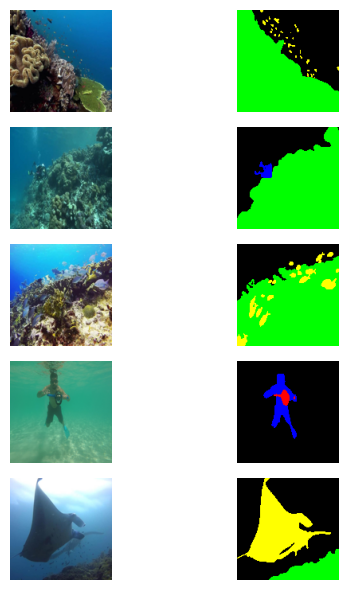

In [43]:
plot_dataset(train_loader)

### Реализация архитектуры сети UNet

Источник: https://neurohive.io/ru/vidy-nejrosetej/u-net-image-segmentation/


In [44]:
#from: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_model.py

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 'same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.25),
        )

    def forward(self, x):
        return self.double_conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x):
        x = self.max_pool(x)
        return self.conv(x)

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim = 1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels = 3, n_classes = 5):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DownSample(64, 128)
        self.down2 = DownSample(128, 256)
        self.down3 = DownSample(256, 512)
        self.dropout = nn.Dropout(0.5)
        self.down4 = DownSample(512, 1024)

        self.up1 = UpSample(1024 + 512, 512)
        self.up2 = UpSample(512 + 256, 256)
        self.up3 = UpSample(256 + 128, 128)
        self.up4 = UpSample(128 + 64, 64)

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.dropout(x4)
        x6 = self.down4(x5)
        x = self.dropout(x6)

        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        logits = self.outc(x)
        return torch.sigmoid(logits)

### Обучение нейросети

Используются метрики: **accuracy** и **intersection over union** (как отдельно по классам, так и среднее значение).

В качестве функции потерь использовалась **BCELoss (Binary Cross Entropy Loss)** (используется в задачах бинарной/многоклассовой классификации)

$$\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = - w_n \left[ y_n \cdot \log x_n + (1 - y_n) \cdot \log (1 - x_n) \right]$$  
- $y$ - true var
- $x$ - predict var 

+ Если $y = 1,$ то $L$ зависит только от $−log(y^{*})$: чем ближе предсказание к $1,$ тем меньше ошибка.
+ Если $y = 0,$ то $L$ зависит только от $−log(1− y^{*})$: чем ближе предсказание к $0,$ тем меньше ошибка.

GPU or CPU: cuda


100%|██████████| 48/48 [00:16<00:00,  2.86it/s]


Epoch: [1/100], Loss: 0.3027, Time: 17.03 


100%|██████████| 48/48 [00:17<00:00,  2.82it/s]


Epoch: [2/100], Loss: 0.2406, Time: 17.25 


100%|██████████| 48/48 [00:17<00:00,  2.80it/s]


Epoch: [3/100], Loss: 0.2336, Time: 17.40 


100%|██████████| 48/48 [00:17<00:00,  2.77it/s]


Epoch: [4/100], Loss: 0.2208, Time: 17.55 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [5/100], Loss: 0.2114, Time: 17.83 


100%|██████████| 48/48 [00:17<00:00,  2.72it/s]


Epoch: [6/100], Loss: 0.2140, Time: 17.86 


100%|██████████| 48/48 [00:17<00:00,  2.71it/s]


Epoch: [7/100], Loss: 0.2016, Time: 17.92 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [8/100], Loss: 0.1980, Time: 17.75 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [9/100], Loss: 0.1918, Time: 17.73 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [10/100], Loss: 0.1909, Time: 17.75 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [11/100], Loss: 0.1856, Time: 17.78 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [12/100], Loss: 0.1863, Time: 17.79 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [13/100], Loss: 0.1918, Time: 17.80 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [14/100], Loss: 0.1819, Time: 17.80 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [15/100], Loss: 0.1736, Time: 17.83 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [16/100], Loss: 0.1701, Time: 17.82 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [17/100], Loss: 0.1756, Time: 17.79 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [18/100], Loss: 0.1678, Time: 17.78 


100%|██████████| 48/48 [00:17<00:00,  2.73it/s]


Epoch: [19/100], Loss: 0.1652, Time: 17.80 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [20/100], Loss: 0.1668, Time: 17.77 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [21/100], Loss: 0.1606, Time: 17.74 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [22/100], Loss: 0.1595, Time: 17.74 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [23/100], Loss: 0.1564, Time: 17.74 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [24/100], Loss: 0.1548, Time: 17.74 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [25/100], Loss: 0.1507, Time: 17.73 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [26/100], Loss: 0.1523, Time: 17.74 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [27/100], Loss: 0.1484, Time: 17.75 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [28/100], Loss: 0.1449, Time: 17.74 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [29/100], Loss: 0.1468, Time: 17.74 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [30/100], Loss: 0.1381, Time: 17.77 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [31/100], Loss: 0.1358, Time: 17.78 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [32/100], Loss: 0.1374, Time: 17.75 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [33/100], Loss: 0.1381, Time: 17.76 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [34/100], Loss: 0.1283, Time: 17.75 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [35/100], Loss: 0.1282, Time: 17.75 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [36/100], Loss: 0.1292, Time: 17.73 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [37/100], Loss: 0.1219, Time: 17.72 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [38/100], Loss: 0.1222, Time: 17.71 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [39/100], Loss: 0.1192, Time: 17.71 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [40/100], Loss: 0.1175, Time: 17.69 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [41/100], Loss: 0.1144, Time: 17.68 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [42/100], Loss: 0.1130, Time: 17.69 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [43/100], Loss: 0.1099, Time: 17.70 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [44/100], Loss: 0.1052, Time: 17.71 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [45/100], Loss: 0.1109, Time: 17.69 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [46/100], Loss: 0.1117, Time: 17.69 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [47/100], Loss: 0.1026, Time: 17.71 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [48/100], Loss: 0.0961, Time: 17.72 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [49/100], Loss: 0.0959, Time: 17.70 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [50/100], Loss: 0.0955, Time: 17.69 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [51/100], Loss: 0.0987, Time: 17.70 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [52/100], Loss: 0.0938, Time: 17.68 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [53/100], Loss: 0.0942, Time: 17.67 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [54/100], Loss: 0.0924, Time: 17.67 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [55/100], Loss: 0.0830, Time: 17.67 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [56/100], Loss: 0.0836, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [57/100], Loss: 0.0806, Time: 17.66 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [58/100], Loss: 0.0844, Time: 17.66 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [59/100], Loss: 0.0800, Time: 17.64 


100%|██████████| 48/48 [00:17<00:00,  2.74it/s]


Epoch: [60/100], Loss: 0.0847, Time: 17.75 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [61/100], Loss: 0.0792, Time: 17.68 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [62/100], Loss: 0.0746, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [63/100], Loss: 0.0723, Time: 17.68 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [64/100], Loss: 0.0738, Time: 17.69 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [65/100], Loss: 0.0725, Time: 17.66 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [66/100], Loss: 0.0702, Time: 17.69 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [67/100], Loss: 0.0712, Time: 17.67 


100%|██████████| 48/48 [00:17<00:00,  2.75it/s]


Epoch: [68/100], Loss: 0.0671, Time: 17.66 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [69/100], Loss: 0.0655, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [70/100], Loss: 0.0646, Time: 17.64 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [71/100], Loss: 0.0639, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [72/100], Loss: 0.0616, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [73/100], Loss: 0.0583, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [74/100], Loss: 0.0635, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [75/100], Loss: 0.0599, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [76/100], Loss: 0.0597, Time: 17.63 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [77/100], Loss: 0.0610, Time: 17.63 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [78/100], Loss: 0.0575, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [79/100], Loss: 0.0564, Time: 17.64 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [80/100], Loss: 0.0524, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [81/100], Loss: 0.0533, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [82/100], Loss: 0.0534, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [83/100], Loss: 0.0522, Time: 17.64 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [84/100], Loss: 0.0540, Time: 17.63 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [85/100], Loss: 0.0548, Time: 17.61 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [86/100], Loss: 0.0512, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [87/100], Loss: 0.0539, Time: 17.61 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [88/100], Loss: 0.0631, Time: 17.60 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [89/100], Loss: 0.0558, Time: 17.61 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [90/100], Loss: 0.0475, Time: 17.61 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [91/100], Loss: 0.0459, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [92/100], Loss: 0.0477, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [93/100], Loss: 0.0469, Time: 17.63 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [94/100], Loss: 0.0485, Time: 17.64 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [95/100], Loss: 0.0545, Time: 17.64 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [96/100], Loss: 0.0506, Time: 17.65 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [97/100], Loss: 0.0472, Time: 17.64 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [98/100], Loss: 0.0467, Time: 17.63 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [99/100], Loss: 0.0459, Time: 17.62 


100%|██████████| 48/48 [00:17<00:00,  2.76it/s]


Epoch: [100/100], Loss: 0.0481, Time: 17.60 


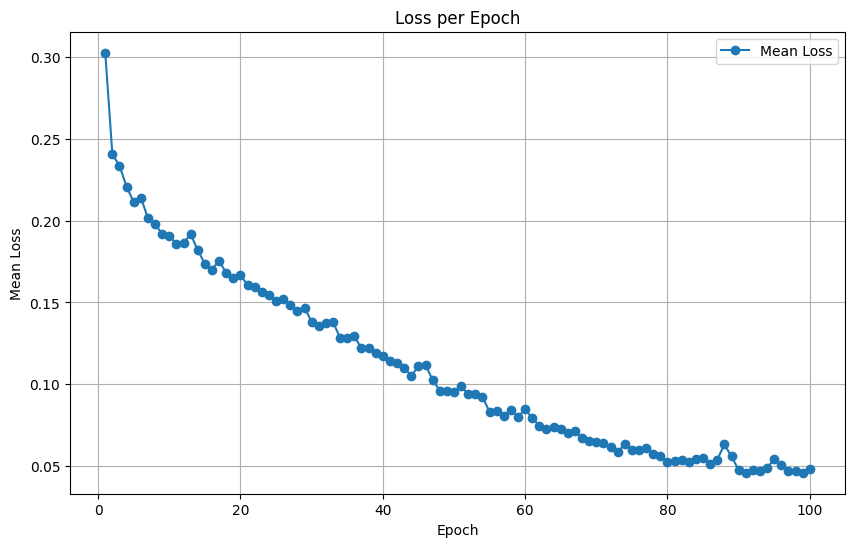

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('GPU or CPU:', device)

net = UNet().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr = learning_rate)
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

loss_epoch_list = []

for epoch in range(Epochs):
    loss_list = []
    time_one = time.time()

    for data in tqdm(train_loader):
        images = data[0].permute(0, 3, 1, 2).to(device)
        labels = data[1].permute(0, 3, 1, 2).to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_list.append(loss)

    mean_loss = torch.stack(loss_list).mean().item()
    loss_epoch_list.append(mean_loss)

    diff_time = time.time() - time_one
    print(f"Epoch: [{epoch + 1}/{Epochs}], Loss: {mean_loss:.4f}, Time: {diff_time:.2f} ")

plt.figure(figsize=(10, 6))
plt.plot(range(1, Epochs + 1), loss_epoch_list, marker='o', label='Mean Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.title('Loss per Epoch')
plt.grid(True)
plt.legend()
plt.show()

accuracy for classes: [0.9385 0.9814 0.9956 0.949  0.8955]
IoU for classes: [0.8555 0.3018 0.1248 0.3147 0.8145]
Accuracy total: 0.9521
IoU total: 0.4819


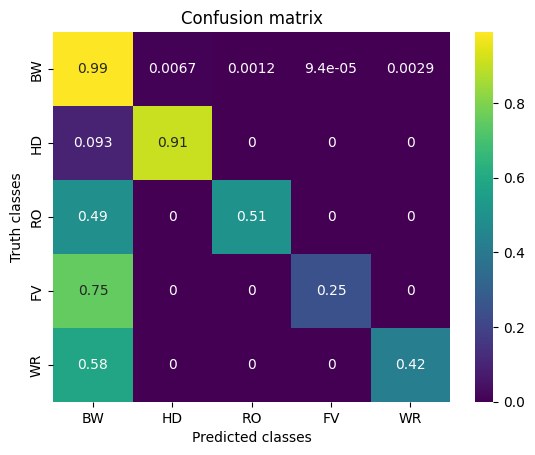

In [47]:
def calculate_IoU(labels, predict):
    intersection = np.logical_and(labels, predict)
    union = np.logical_or(labels, predict)
    iou_score = np.sum(intersection) / (0.0001 + np.sum(union))
    return iou_score


def compute_metrics(loader):
    accuracy_list, IoU_list, cm_label, cm_pred = [], [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.permute(0, 3, 1, 2).to(device)
            labels = labels.permute(0, 3, 1, 2).numpy()
            predict = net(images)
            predict = torch.where(predict < torch.tensor(0.5),
                                            torch.tensor(0),
                                            torch.tensor(1)).cpu().numpy()

            for elem in range(1, 6):
                elem = elem - 1
                labels_5_int = labels[:, elem, :, :]
                predict_5_int = predict[:, elem, :, :]

                labels_5_int = np.where(labels_5_int != 1, 0, elem + 1)
                predict_5_int = np.where(predict_5_int != 1, 0, elem + 1)
                labels[:, elem, :, :] = labels_5_int
                predict[:, elem, :, :] = predict_5_int

            cm_label.append(labels)
            cm_pred.append(predict)

            temp_acc, temp_iou = [], []
            for k in range(5):
                acc = np.mean(predict[:, k, :, :] == labels[:, k, :, :])
                IoU = calculate_IoU(labels[:, k, :, :], predict[:, k, :, :])
                temp_acc.append(acc)
                temp_iou.append(IoU)
            accuracy_list.append(temp_acc)
            IoU_list.append(temp_iou)

    accuracy_list = np.array(accuracy_list)
    IoU_list = np.array(IoU_list)

    print(f'accuracy for classes: {np.mean(accuracy_list, axis = 0, dtype = np.float16)}')
    print(f'IoU for classes: {np.mean(IoU_list, axis = 0, dtype = np.float16)}')
    print(f'Accuracy total: {np.mean(accuracy_list, dtype = np.float16):.4f}')
    print(f'IoU total: {np.mean(IoU_list, dtype = np.float16):.4f}')

    cm_label = np.concatenate(cm_label, axis = 0)
    cm_pred = np.concatenate(cm_pred, axis = 0)
    cm_label = cm_label.flatten()
    cm_pred = cm_pred.flatten()

    name_class = ['BW', 'HD', 'RO', 'FV', 'WR']
    cm = confusion_matrix(cm_label, cm_pred, labels = np.arange(5), normalize = 'true')
    sea.heatmap(cm, annot = True, cmap = 'viridis', xticklabels = name_class, yticklabels = name_class)
    plt.xlabel('Predicted classes')
    plt.ylabel('Truth classes')
    plt.title('Confusion matrix')
    plt.show()

compute_metrics(test_loader)

In [48]:
def plot_predict(loader):
    def plot_img(images, labels, predicts):
        fig, axes = plt.subplots(6, 3, figsize=(6, 6))  # 3 столбца: изображение, настоящая маска, предсказанная маска

        # Цвета для масок
        mask_RGB = [[0, 0, 0],  # Background (black)
                    [0, 0, 1],  # Human (blue)
                    [1, 0, 0],  # Robot (red)
                    [1, 1, 0],  # Fish (yellow)
                    [0, 1, 0]]  # NewClass (green)

        for i in range(6):
            for j in range(3):  # Всегда 3 столбца
                index = i * 3 + j  # Индекс для отображения каждого изображения

                if index >= len(images):  # Проверка, чтобы не выйти за пределы массива изображений
                    break

                # Показываем исходное изображение слева
                axes[i, 0].imshow(images[index].cpu().permute(1, 2, 0))  # Преобразуем из [C, H, W] в [H, W, C]
                axes[i, 0].axis('off')

                # Показываем настоящую маску по центру
                RGB_mask = np.zeros((image_size[0], image_size[1], 3))
                for k in range(5):  # 5 классов
                    mask = labels[index, :, :, k]
                    RGB_mask[mask > 0] = mask_RGB[k]
                axes[i, 1].imshow(images[index].cpu().permute(1, 2, 0))
                axes[i, 1].imshow(RGB_mask)  # Наложение настоящей маски
                axes[i, 1].axis('off')

                # Показываем предсказанную маску справа
                RGB_mask_pred = np.zeros((image_size[0], image_size[1], 3))
                for k in range(5):  # 5 классов
                    mask_pred = predicts[index, :, :, k]
                    RGB_mask_pred[mask_pred > 0] = mask_RGB[k]
                axes[i, 2].imshow(images[index].cpu().permute(1, 2, 0))
                axes[i, 2].imshow(RGB_mask_pred)  # Наложение предсказанной маски
                axes[i, 2].axis('off')

        plt.tight_layout()
        plt.show()

    with torch.no_grad():
        for images, labels in loader:
            images = images.permute(0, 3, 1, 2).to(device)  # Преобразуем в [B, C, H, W]
            labels = labels
            predict = net(images)  # Получаем предсказания от модели
            predict = torch.where(predict < 0.5, torch.tensor(0), torch.tensor(1)).permute(0, 2, 3, 1).cpu()  # Бинаризация предсказаний
            break

    plot_img(images, labels, predict)  # Отображаем изображения, маски и предсказания

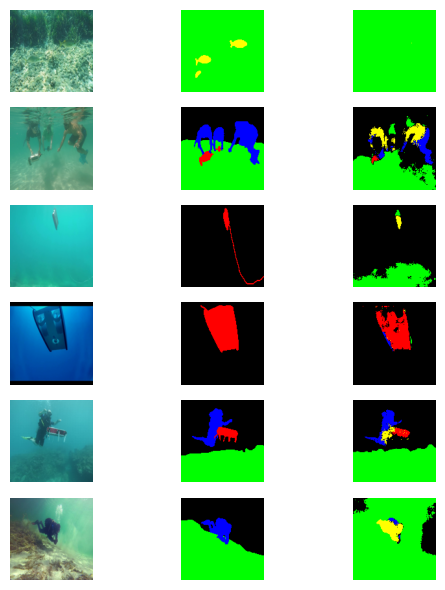

In [49]:
plot_predict(test_loader)